In [1]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Created wheel for pandas-profiling: filename=pandas_profiling-2.8.0-py2.py3-none-any.whl size=259932 sha256=1c898952dd616b848dd3a0506db9818962a568de9ced2406ac3324fd16ebadfa
  Stored in directory: /tmp/pip-ephem-wheel-cache-0x3kz80d/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
Successfully built pandas-profiling


In [2]:
from google.colab import auth
auth.authenticate_user()
print('ok')

ok


In [5]:
from google.cloud import bigquery
from tabulate import tabulate
import pandas as pd

project_id = 'amiable-nirvana-236805'
client = bigquery.Client(project=project_id)

train = client.query('''SELECT * FROM `amiable-nirvana-236805.jeju_data_ver1.201901_202003_train` WHERE RAND()<10000
/(SELECT COUNT(*) FROM `amiable-nirvana-236805.jeju_data_ver1.201901_202003_train`)''').to_dataframe()


In [6]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, title='Pandas Profiling Report',explorative=True)
profile.to_notebook_iframe()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error, mean_absolute_error

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm, skew

In [8]:
print('Pandas : %s' %(pd.__version__))
print('Numpy : %s' %(np.__version__))
print('Scikit-Learn : %s' %(sklearn.__version__))
print('seaborn : %s' %(sns.__version__))
print('matplotlib : %s' %(matplotlib.__version__))
!python --version

Pandas : 1.0.5
Numpy : 1.18.5
Scikit-Learn : 0.22.2.post1
seaborn : 0.10.1
matplotlib : 3.2.2
Python 3.6.9


In [9]:
def grap_year(data):
  data = str(data)
  return int(data[:4])
def grap_month(data):
  data = str(data)
  return int(data[4:])

In [10]:
data = train.copy()
data = data.fillna('')
print(data['REG_YYMM'].head())

0    201907
1    201902
2    201904
3    201903
4    201902
Name: REG_YYMM, dtype: int64


In [11]:
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data = data.drop(['REG_YYMM'],axis=1)
data.head()

CARD_SIDO_NM CARD_CCG_NM            STD_CLSS_NM  ... CNT  year month
0           경기     성남시 분당구                 버스 운송업  ...  12  2019     7
1           서울         구로구                 버스 운송업  ...  11  2019     2
2           서울         강남구  피자 햄버거 샌드위치 및 유사 음식점업  ...   5  2019     4
3           부산        해운대구        그외 기타 스포츠시설 운영업  ...   9  2019     3
4           서울         강남구  피자 햄버거 샌드위치 및 유사 음식점업  ...  12  2019     2

[5 rows x 13 columns]

In [14]:
df = data.drop(['CARD_CCG_NM','HOM_CCG_NM'],axis=1)
columns = ['CARD_SIDO_NM','STD_CLSS_NM','HOM_SIDO_NM','AGE','SEX_CTGO_CD','FLC','year','month']
df = df.groupby(columns).sum().reset_index(drop=False)

In [15]:
dtypes = df.dtypes
encoders = {}
for column in df.columns:
  if str(dtypes[column]) == 'object':
    encoder = LabelEncoder()
    encoder.fit(df[column])
    encoders[column] = encoder

df_num = df.copy()
for column in encoders.keys():
  encoder = encoders[column]
  df_num[column] = encoder.transform(df[column])

In [16]:
from sklearn.model_selection import train_test_split

X_data, y_data = df_num.loc[:,df_num.columns !='AMT'], df.loc[:,df_num.columns == 'AMT']
y_target = y_data['AMT']
X_data = X_data.drop(['CSTMR_CNT','CNT'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_data,y_target,test_size=0.3,random_state=126,shuffle=True)


 mu = 2606168.34 and sigma = 22525005.32



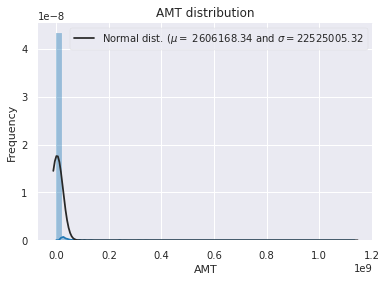

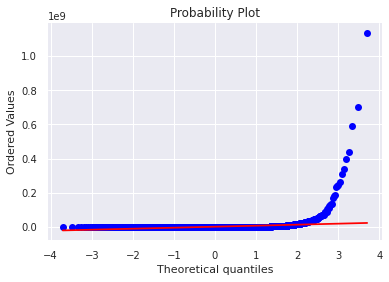

In [19]:
sns.distplot(y_train, fit=norm);
(mu,sigma) = norm.fit(y_train)
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu,sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=${:.2f}'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution')

fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()


 mu = 12.67 and sigma = 1.71



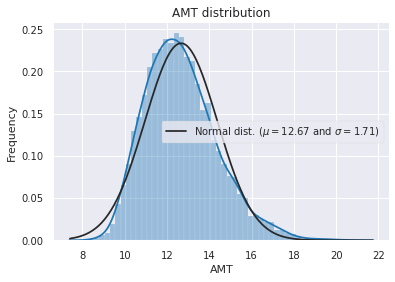

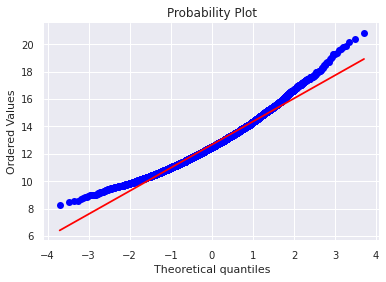

In [20]:
y_train = np.log1p(y_train)

sns.distplot(y_train, fit=norm);
(mu, sigma) = norm.fit(y_train)
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu,sigma))
plt.legend(['Normal dist. ($\mu=${:.2f} and $\sigma=${:.2f})'.format(mu,sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution')

fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

In [21]:
# 훈련
gbm = GradientBoostingRegressor(n_estimators=4000);
gbm.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=4000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [22]:
def rmsle(y, pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred)**2
  rmsle = np.sqrt(np.mean(squared_error))
  return print('RMSLE: {0:.3f}'.format(rmsle))

In [23]:
eval_pred = gbm.predict(X_test)
eval_pred = np.expm1(eval_pred)
rmsle(y_test, eval_pred)

RMSLE: 1.560


In [ ]:
from itertools import product

CAR_SIDO_NMs = df_num['CARD']